In [1]:
!pip install nsepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import sys
print(sys.version)

3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [3]:
# Importing dependencies
from nsepy import get_history as gh
import numpy as np
np.random.seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')
from textblob import TextBlob
from wordcloud import WordCloud
import re

In [4]:
start = dt.datetime(2016,1,1)
end = dt.datetime(2022,6,30)

In [5]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [6]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']

In [7]:
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time 
    Y_hat = model.predict(X_test)
    mae = mean_absolute_error(Y_test,Y_hat)
    r = r2_score(Y_test,Y_hat) # Higher the r2 score more is the correlation between the variables
    return  mae, r, Y_test, Y_hat

In [8]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'g')
    plt.xlabel('Day')
    plt.ylabel('Stock Trend')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [9]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

# **TFL**

In [10]:
df = gh(symbol='TFL',start=start,end=end)
df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2022-06-24,TFL,EQ,6.90,7.15,7.20,7.15,7.20,7.20,7.17,2278,1.633990e+09,14,2278,1.0000
2022-06-27,TFL,EQ,7.20,7.35,7.55,7.05,7.35,7.35,7.29,7055,5.139855e+09,75,262,0.0371
2022-06-28,TFL,EQ,7.35,7.00,7.70,7.00,7.70,7.70,7.42,10316,7.654900e+09,36,5507,0.5338
2022-06-29,TFL,EQ,7.70,8.05,8.05,8.05,8.05,8.05,8.05,2532,2.038260e+09,7,2532,1.0000
2022-06-30,TFL,EQ,8.05,8.45,8.45,8.45,8.45,8.45,8.45,1046,8.838700e+08,7,1046,1.0000


In [11]:
#Variables
df1 = (df)[['Open','High','Low','Close','Prev Close','VWAP','Turnover','Last','Volume']]
df1=pd.DataFrame(df)
df1.index=pd.to_datetime(df.index)
df1

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2016-01-04,TFL,EQ,5.75,6.00,6.00,6.00,6.00,6.00,6.00,490,2.940000e+08,3,490,1.0000
2016-01-05,TFL,EQ,6.00,6.20,6.30,6.20,6.30,6.30,6.26,10000,6.260000e+09,11,10000,1.0000
2016-01-06,TFL,EQ,6.30,6.60,6.60,6.00,6.10,6.10,6.20,1781,1.103395e+09,10,1581,0.8877
2016-01-07,TFL,EQ,6.10,6.40,6.40,6.40,6.40,6.40,6.40,2330,1.491200e+09,5,2330,1.0000
2016-01-11,TFL,EQ,6.40,6.70,6.70,6.70,6.70,6.70,6.70,2000,1.340000e+09,1,2000,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-24,TFL,EQ,6.90,7.15,7.20,7.15,7.20,7.20,7.17,2278,1.633990e+09,14,2278,1.0000
2022-06-27,TFL,EQ,7.20,7.35,7.55,7.05,7.35,7.35,7.29,7055,5.139855e+09,75,262,0.0371
2022-06-28,TFL,EQ,7.35,7.00,7.70,7.00,7.70,7.70,7.42,10316,7.654900e+09,36,5507,0.5338


In [12]:
#Addition of new column for Lift parameter
df1['Lift']=df1['Close']-df1['Open']

In [13]:
# Extracting the series
series = df1[['Close','Turnover','Lift']]
print(series.shape)
print(series.tail())

(1037, 3)
            Close      Turnover  Lift
Date                                 
2022-06-24   7.20  1.633990e+09  0.05
2022-06-27   7.35  5.139855e+09  0.00
2022-06-28   7.70  7.654900e+09  0.70
2022-06-29   8.05  2.038260e+09  0.00
2022-06-30   8.45  8.838700e+08  0.00


In [14]:
# Train Val Test Split

train_start = dt.date(2016,1,1)
train_end = dt.date(2019,12,31)
train_data = series.loc[train_start:train_end]


val_start = dt.date(2020,1,1)
val_end = dt.date(2020,12,31)
val_data = series.loc[val_start:val_end]


test_start = dt.date(2021,1,1)
test_end = dt.date(2022,6,30)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(709, 3) (122, 3) (206, 3)


In [15]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)# Fit to data then transform
val = sc.transform(val_data) #Scale features of val_data based on feature range
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(709, 3) (122, 3) (206, 3)


In [16]:
timesteps = 50
hl = [40,35] #Neurons in each layer
lr = 1e-3 #Learning rate 0.001
batch_size = 30
num_epochs = 150

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 139: early stopping


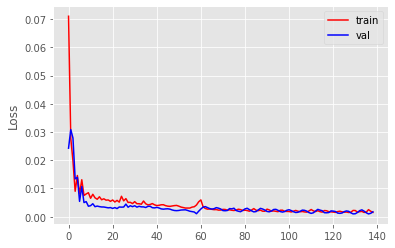

In [17]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MAE = 0.046857016384471914
R-Squared Score = 0.7766796678578343


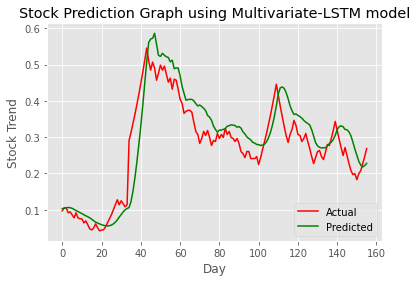

In [18]:
mae, r2_value,true,predicted = evaluate_model(model,test,timesteps)

print('MAE = {}'.format(mae))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)

# **SALSTEEL**

In [19]:
_2df = gh(symbol='SALSTEEL',start=start,end=end)
_2df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2022-06-24,SALSTEEL,EQ,7.90,7.90,8.25,7.90,8.25,8.25,8.21,67023,5.500284e+10,357,46495,0.6937
2022-06-27,SALSTEEL,EQ,8.25,8.40,8.50,8.25,8.35,8.35,8.36,77716,6.494078e+10,332,49106,0.6319
2022-06-28,SALSTEEL,EQ,8.35,8.50,8.50,8.25,8.50,8.40,8.39,27637,2.318282e+10,266,18189,0.6581
2022-06-29,SALSTEEL,EQ,8.40,8.65,8.65,8.25,8.25,8.30,8.37,49845,4.171797e+10,273,29293,0.5877
2022-06-30,SALSTEEL,EQ,8.30,8.55,8.65,8.20,8.60,8.55,8.48,105188,8.917568e+10,1102,55974,0.5321


In [20]:
_2df2 = (_2df)[['Open','High','Low','Close','Prev Close','VWAP','Turnover','Last','Volume']]
print(_2df2)
_2df2.shape

            Open  High   Low  Close  Prev Close  VWAP      Turnover  Last  \
Date                                                                        
2016-01-01  3.40  3.50  3.25   3.40        3.25  3.38  2.401303e+10  3.40   
2016-01-04  3.40  3.40  3.15   3.20        3.40  3.27  7.330210e+09  3.20   
2016-01-05  3.50  3.50  3.10   3.15        3.20  3.20  3.339022e+10  3.25   
2016-01-06  3.30  3.30  3.15   3.15        3.15  3.21  1.008886e+10  3.15   
2016-01-07  3.00  3.15  3.00   3.10        3.15  3.06  1.048175e+10  3.15   
...          ...   ...   ...    ...         ...   ...           ...   ...   
2022-06-24  7.90  8.25  7.90   8.25        7.90  8.21  5.500284e+10  8.25   
2022-06-27  8.40  8.50  8.25   8.35        8.25  8.36  6.494078e+10  8.35   
2022-06-28  8.50  8.50  8.25   8.40        8.35  8.39  2.318282e+10  8.50   
2022-06-29  8.65  8.65  8.25   8.30        8.40  8.37  4.171797e+10  8.25   
2022-06-30  8.55  8.65  8.20   8.55        8.30  8.48  8.917568e+10  8.60   

(1220, 9)

In [21]:
_2df2['Lift'] = _2df2['Close'] - _2df2['Open']
_2df2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Prev Close,VWAP,Turnover,Last,Volume,Lift
Date,,,,,,,,,,
2016-01-01,3.40,3.50,3.25,3.40,3.25,3.38,2.401303e+10,3.40,70955,0.00
2016-01-04,3.40,3.40,3.15,3.20,3.40,3.27,7.330210e+09,3.20,22437,-0.20
2016-01-05,3.50,3.50,3.10,3.15,3.20,3.20,3.339022e+10,3.25,104311,-0.35
2016-01-06,3.30,3.30,3.15,3.15,3.15,3.21,1.008886e+10,3.15,31453,-0.15
2016-01-07,3.00,3.15,3.00,3.10,3.15,3.06,1.048175e+10,3.15,34258,0.10
...,...,...,...,...,...,...,...,...,...,...
2022-06-24,7.90,8.25,7.90,8.25,7.90,8.21,5.500284e+10,8.25,67023,0.35
2022-06-27,8.40,8.50,8.25,8.35,8.25,8.36,6.494078e+10,8.35,77716,-0.05
2022-06-28,8.50,8.50,8.25,8.40,8.35,8.39,2.318282e+10,8.50,27637,-0.10


In [22]:
# Extracting the series
series2 = _2df2[['Close','Turnover','Lift']]
print(series2.shape)
print(series2.tail())

(1220, 3)
            Close      Turnover  Lift
Date                                 
2022-06-24   8.25  5.500284e+10  0.35
2022-06-27   8.35  6.494078e+10 -0.05
2022-06-28   8.40  2.318282e+10 -0.10
2022-06-29   8.30  4.171797e+10 -0.35
2022-06-30   8.55  8.917568e+10  0.00


In [23]:
# Train Val Test Split

train_start2 = dt.date(2016,1,1)
train_end2 = dt.date(2019,12,31)
train_data2 = series2.loc[train_start2:train_end2]


val_start2 = dt.date(2020,1,1)
val_end2 = dt.date(2020,12,31)
val_data2 = series2.loc[val_start2:val_end2]

test_start2 = dt.date(2021,1,1)
test_end2 = dt.date(2022,6,30)
test_data2 = series2.loc[test_start2:test_end2]

print(train_data2.shape,val_data2.shape,test_data2.shape)

(809, 3) (156, 3) (255, 3)


In [24]:
# Normalisation
sc2 = MinMaxScaler()
train2 = sc2.fit_transform(train_data2)
val2 = sc2.transform(val_data2)
test2 = sc2.transform(test_data2)
print(train2.shape,val2.shape,test2.shape)

(809, 3) (156, 3) (255, 3)


In [25]:
timesteps = 60
hl = [40,35] #Neurons in each layer
lr = 1e-3 #Learning rate 0.001
batch_size = 40
num_epochs = 150

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


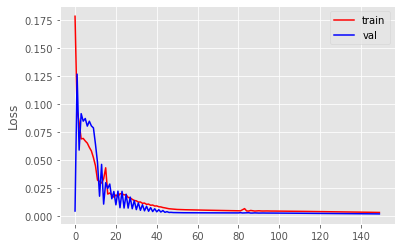

In [26]:
model2,train_error2,val_error2 = fit_model(train2,val2,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error2,val_error2)

MAE = 0.18357816279228
R-Squared Score = 0.32225206281808794


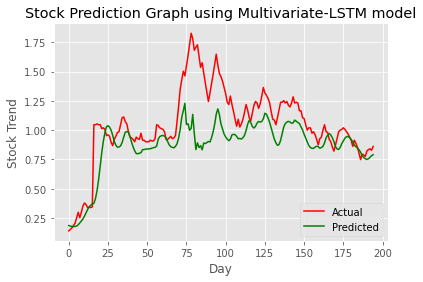

In [27]:
mae2, r2_value2,true2,predicted2 = evaluate_model(model2,test2,timesteps)

print('MAE = {}'.format(mae2))
print('R-Squared Score = {}'.format(r2_value2))
plot_data(true2,predicted2)

# **SOUTHBANK**

In [28]:
_3df = gh(symbol='SOUTHBANK',start=start,end=end)
_3df.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2022-06-24,SOUTHBANK,EQ,7.45,7.50,7.55,7.45,7.50,7.45,7.48,1609758,1.204145e+12,5195,1049240,0.6518
2022-06-27,SOUTHBANK,EQ,7.45,7.55,7.75,7.50,7.65,7.60,7.65,4298727,3.287803e+12,5486,1733969,0.4034
2022-06-28,SOUTHBANK,EQ,7.60,7.65,7.65,7.55,7.65,7.60,7.60,942897,7.169120e+11,4345,564766,0.5990
2022-06-29,SOUTHBANK,EQ,7.60,7.60,7.75,7.55,7.70,7.65,7.65,2800128,2.143387e+12,5070,1074083,0.3836
2022-06-30,SOUTHBANK,EQ,7.65,7.70,7.75,7.55,7.60,7.60,7.66,1317340,1.008601e+12,7965,655753,0.4978


In [29]:
#Variables for training
_3df1 = (_3df)[['Open','High','Low','Close','Prev Close','VWAP','Turnover','Last','Volume']]
print(_3df1)
_3df1.shape


             Open   High    Low  Close  Prev Close   VWAP      Turnover  \
Date                                                                      
2016-01-01  19.30  19.70  19.30  19.65       19.35  19.55  3.449777e+12   
2016-01-04  19.65  20.10  19.45  19.55       19.65  19.72  6.016627e+12   
2016-01-05  19.60  20.05  19.50  19.95       19.55  19.76  5.650642e+12   
2016-01-06  20.10  20.35  19.50  20.05       19.95  20.02  9.327879e+12   
2016-01-07  19.65  19.90  19.45  19.55       20.05  19.59  1.120506e+13   
...           ...    ...    ...    ...         ...    ...           ...   
2022-06-24   7.50   7.55   7.45   7.45        7.45   7.48  1.204145e+12   
2022-06-27   7.55   7.75   7.50   7.60        7.45   7.65  3.287803e+12   
2022-06-28   7.65   7.65   7.55   7.60        7.60   7.60  7.169120e+11   
2022-06-29   7.60   7.75   7.55   7.65        7.60   7.65  2.143387e+12   
2022-06-30   7.70   7.75   7.55   7.60        7.65   7.66  1.008601e+12   

             Last   Volu

(1609, 9)

In [30]:
_3df1['Lift'] = _3df1['Close'] - _3df1['Open']
_3df1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Prev Close,VWAP,Turnover,Last,Volume,Lift
Date,,,,,,,,,,
2016-01-01,19.30,19.70,19.30,19.65,19.35,19.55,3.449777e+12,19.70,1764925,0.35
2016-01-04,19.65,20.10,19.45,19.55,19.65,19.72,6.016627e+12,19.55,3051436,-0.10
2016-01-05,19.60,20.05,19.50,19.95,19.55,19.76,5.650642e+12,19.90,2860295,0.35
2016-01-06,20.10,20.35,19.50,20.05,19.95,20.02,9.327879e+12,20.05,4658414,-0.05
2016-01-07,19.65,19.90,19.45,19.55,20.05,19.59,1.120506e+13,19.60,5720746,-0.10
...,...,...,...,...,...,...,...,...,...,...
2022-06-24,7.50,7.55,7.45,7.45,7.45,7.48,1.204145e+12,7.50,1609758,-0.05
2022-06-27,7.55,7.75,7.50,7.60,7.45,7.65,3.287803e+12,7.65,4298727,0.05
2022-06-28,7.65,7.65,7.55,7.60,7.60,7.60,7.169120e+11,7.65,942897,-0.05


In [31]:
# Extracting the series
series3 = _3df1[['Close','Turnover','Lift']]
print(series3.shape)
print(series3.tail())

(1609, 3)
            Close      Turnover  Lift
Date                                 
2022-06-24   7.45  1.204145e+12 -0.05
2022-06-27   7.60  3.287803e+12  0.05
2022-06-28   7.60  7.169120e+11 -0.05
2022-06-29   7.65  2.143387e+12  0.05
2022-06-30   7.60  1.008601e+12 -0.10


In [32]:
# Train Val Test Split
train_start3 = dt.date(2016,1,1)
train_end3 = dt.date(2019,12,31)
train_data3 = series3.loc[train_start3:train_end3]

val_start3 = dt.date(2020,1,1)
val_end3 = dt.date(2020,12,31)
val_data3 = series3.loc[val_start3:val_end3]


test_start3 = dt.date(2021,1,1)
test_end3 = dt.date(2022,6,30)
test_data3 = series3.loc[test_start3:test_end3]

print(train_data3.shape,val_data3.shape,test_data3.shape)

(986, 3) (252, 3) (371, 3)


In [33]:
# Normalisation
sc3 = MinMaxScaler()
train3 = sc3.fit_transform(train_data3)
val3 = sc3.transform(val_data3)
test3 = sc3.transform(test_data3)
print(train3.shape,val3.shape,test3.shape)

(986, 3) (252, 3) (371, 3)


In [34]:
timesteps = 30
hl = [40,35] #Neurons in each layer
lr = 1e-3 #Learning rate 0.001
batch_size = 30
num_epochs = 150

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


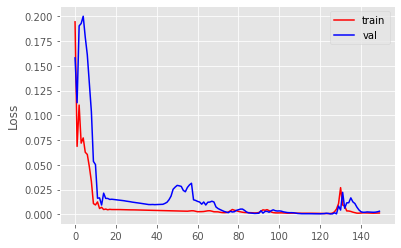

In [35]:
model3,train_error3,val_error3 = fit_model(train3,val3,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error3,val_error3)

MAE = 0.02311991336557573
R-Squared Score = 0.7368346714967338


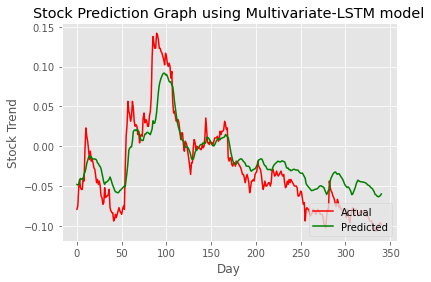

In [36]:
mae3, r2_value3,true3,predicted3 = evaluate_model(model3,test3,timesteps)

print('MAE = {}'.format(mae3))
print('R-Squared Score = {}'.format(r2_value3))
plot_data(true3,predicted3)